In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pylab as plt
# BDay is business day, not birthday...
from pandas.tseries.offsets import BDay

prc1_df = pd.read_excel(r'Futures.xlsx', sheet_name="Price of First Contract", parse_dates=['Dates'])
prc2_df = pd.read_excel(r'Futures.xlsx', sheet_name="Price of Second Contract", parse_dates=['Dates']) 
notice_date_df = pd.read_excel(r'Futures.xlsx', sheet_name="Notice Date", parse_dates=['Dates']) 
last_trade_date_df = pd.read_excel(r'Futures.xlsx', sheet_name="Last Trade Date", parse_dates=['Dates']) 
delivery_date_df = pd.read_excel(r'Futures.xlsx', sheet_name="Delivery Date", parse_dates=['Dates']) 
prc1_df = prc1_df.set_index('Dates').ffill()
prc2_df = prc2_df.set_index('Dates').ffill()
notice_date_df = notice_date_df.set_index('Dates').ffill()
last_trade_date_df = last_trade_date_df.set_index('Dates').ffill()
delivery_date_df = delivery_date_df.set_index('Dates').ffill()


In [20]:
# prc2_df.diff()['AD2 CURNCY'].plot()
# plt.show()

In [10]:
# prc1_df = prc1_df.truncate(after='2016-12-31').iloc[:,-5]
# prc2_df = prc2_df.truncate(after='2016-12-31').iloc[:,-5]
# delivery_date_df = delivery_date_df.truncate(after='2016-12-31').iloc[:, -5]
# last_trade_date_df = last_trade_date_df.truncate(after='2016-12-31').iloc[:, -5]
# notice_date_df = notice_date_df.truncate(after='2016-12-31').iloc[:, -5]

In [11]:
def get_roll_status(dt_df, prc_df, DAYS_ADVANCE=3):
    roll_dates = dt_df.min(axis=1) - BDay(DAYS_ADVANCE)
    dt_df['Roll Date'] = roll_dates
    dt_df['Expiry Date'] = dt_df['FUT_LAST_TRADE_DT']
    roll_status = pd.DataFrame(index=prc_df.index, columns=["Roll", "Expiry", "Status"])
    roll_status["Roll"] = prc_df.index.isin(dt_df["Roll Date"])
    roll_status["Expiry"] = prc_df.index.isin(dt_df["Expiry Date"])
    tmp = roll_status["Status"].copy()
    condition1 = (roll_status["Roll"] == True)
    condition2 = (roll_status["Expiry"] == True)
    tmp.loc[condition1] = "Roll"
    tmp.loc[condition2] = "Expiration"
    roll_status["Status"] = tmp
    idx_start = roll_status.index[roll_status.Roll == True]
    idx_end = roll_status.index[roll_status.Expiry == True]
    idx = list(zip(list(idx_start), list(idx_end)))  # required sequences
    
    for x in idx:
        roll_status["Status"].loc[x[0]:x[1]].fillna("Post-Roll", inplace=True)
    
    roll_status["Status"].fillna("Pre-Roll", inplace=True)
    return roll_status

In [12]:
def adjust_prices(prc_df, roll_status):
    ret_df = prc_df.diff()
    ret_df["Returns"] = prc_df.iloc[:, 0] - prc_df.iloc[:, 1].shift(1)
    ret_df["Adjusted Returns"] = np.nan
    ret_df["Adjusted Returns"][roll_status["Status"].shift() == "Pre-Roll"] = ret_df.iloc[:, 0][roll_status["Status"].shift(1) == "Pre-Roll"] 
    ret_df["Adjusted Returns"][roll_status["Status"].shift() == "Post-Roll"] = ret_df.iloc[:, 1][roll_status["Status"].shift(1) == "Post-Roll"]
    ret_df["Adjusted Returns"][roll_status["Status"].shift() == "Roll"] = ret_df.iloc[:, 1][roll_status["Status"].shift(1) == "Roll"]
    ret_df["Adjusted Returns"][roll_status["Status"].shift() == "Expiration"] = ret_df["Returns"][roll_status["Status"].shift(1) == "Expiration"]
    return ret_df["Adjusted Returns"]

In [13]:
N = len(prc1_df.columns)
column_names = [prc1_df.columns[i].replace('1','') for i in range(0, N)]
ret_adj_df = pd.DataFrame([], columns=column_names)
for i in range(0, N):
    dates_df = pd.concat([last_trade_date_df.iloc[:,i], notice_date_df.iloc[:,i], delivery_date_df.iloc[:,i]], 
                         axis=1,
                         keys= ['FUT_LAST_TRADE_DT', 'FUT_NOTICE_FIRST', 'FUT_DLV_DT_FIRST'])
    prc12_df = pd.concat([prc1_df.iloc[:, i], prc2_df.iloc[:, i]], axis=1)
    roll_status = get_roll_status(dates_df, prc12_df, 3)
    ret_adj_df.iloc[:, i] = adjust_prices(prc12_df, roll_status)

In [14]:
dates_df

,FUT_LAST_TRADE_DT,FUT_NOTICE_FIRST,FUT_DLV_DT_FIRST,Roll Date,Expiry Date
Dates,,,,,
1985-11-29,NaT,NaT,NaT,NaT,NaT
1985-12-31,NaT,NaT,NaT,NaT,NaT
1986-01-31,NaT,NaT,NaT,NaT,NaT
1986-02-28,NaT,NaT,NaT,NaT,NaT
1986-03-31,NaT,NaT,NaT,NaT,NaT
...,...,...,...,...,...
2022-06-30,2022-09-16,2022-09-16,2022-09-16,2022-09-13,2022-09-16
2022-07-29,2022-09-16,2022-09-16,2022-09-16,2022-09-13,2022-09-16
2022-08-31,2022-09-16,2022-09-16,2022-09-16,2022-09-13,2022-09-16


In [15]:
prices_df = ret_adj_df.cumsum()
prices_df.to_csv("prices.csv")

AD CURNCY


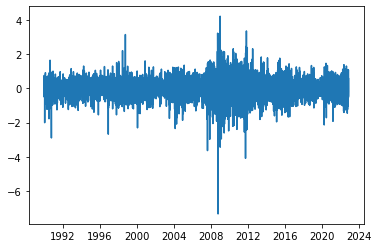

BP CURNCY


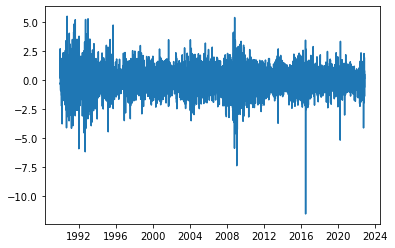

CD CURNCY


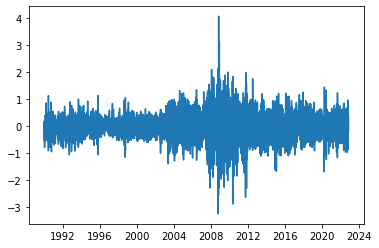

NV CURNCY


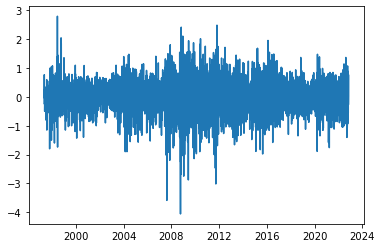

PE CURNCY


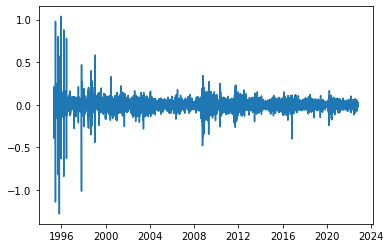

RP CURNCY


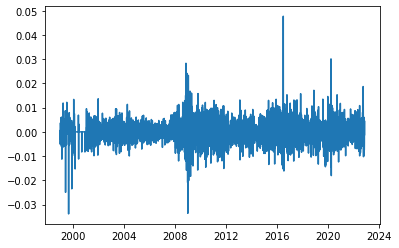

CF INDEX


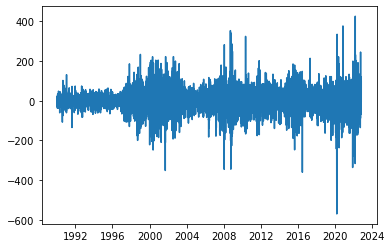

DJ INDEX


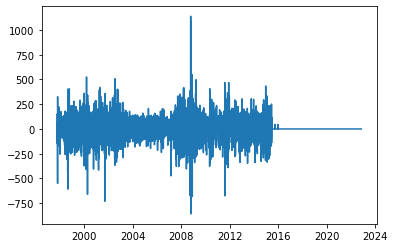

EO INDEX


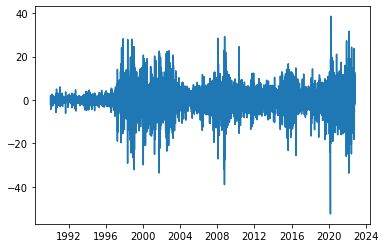

ES INDEX


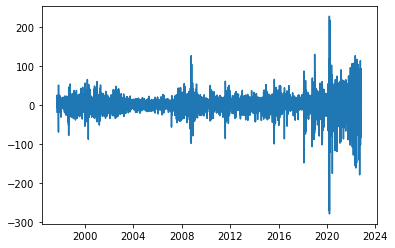

FA INDEX


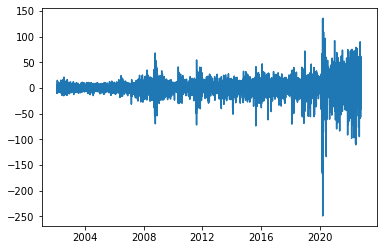

GX INDEX


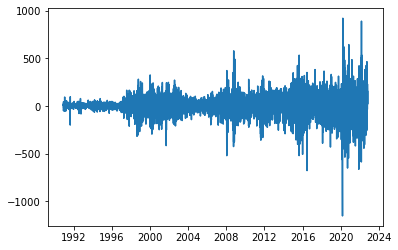

HI INDEX


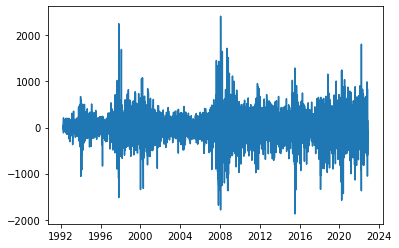

IS INDEX


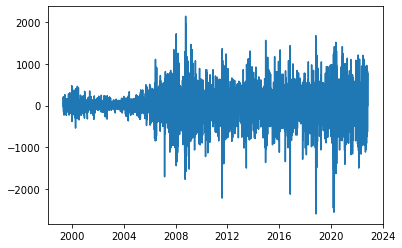

MES INDEX


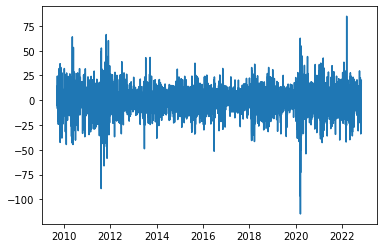

ND INDEX


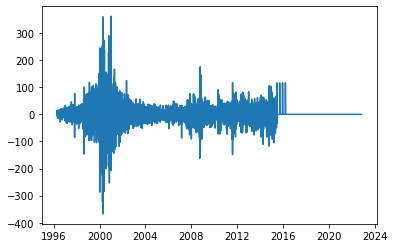

NK INDEX


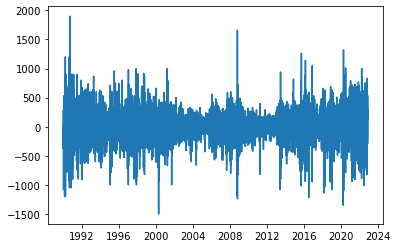

NX INDEX


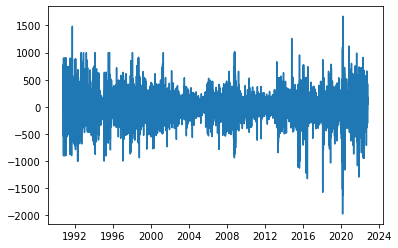

PT INDEX


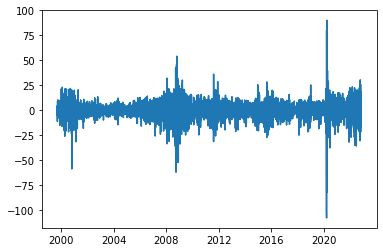

SP INDEX


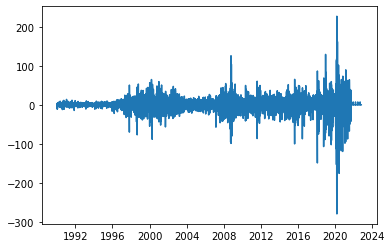

TP INDEX


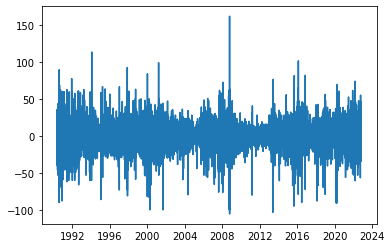

FVS INDEX


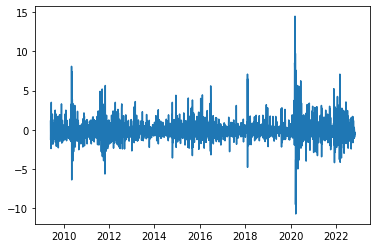

VG INDEX


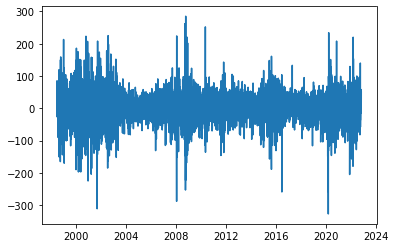

VH INDEX


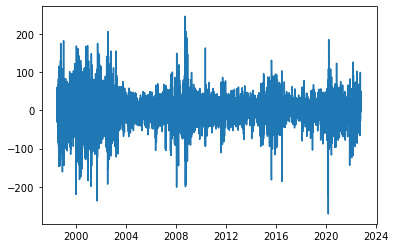

VHS INDEX


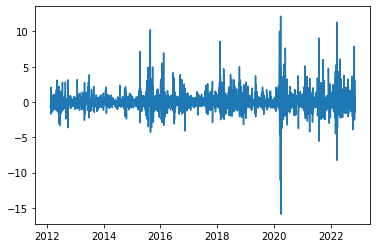

UX INDEX


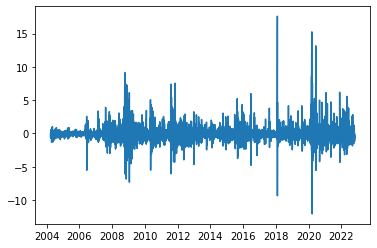

JVI INDEX


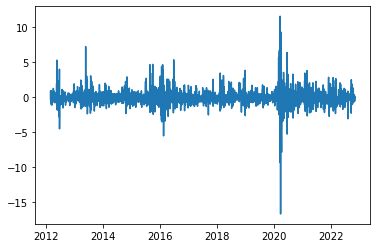

Z  INDEX


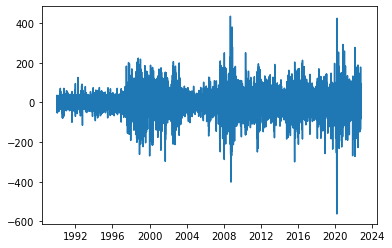

BTS COMDTY


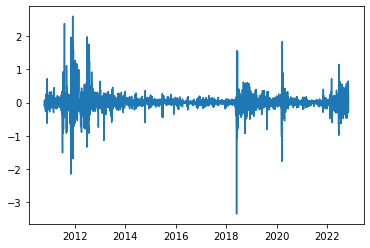

DU COMDTY


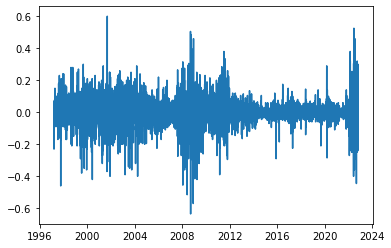

ED COMDTY


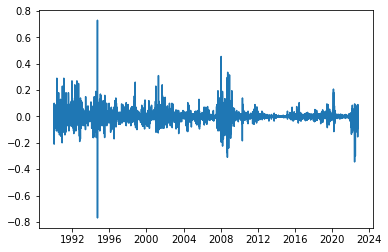

ER COMDTY


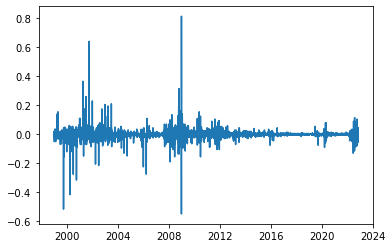

FB COMDTY


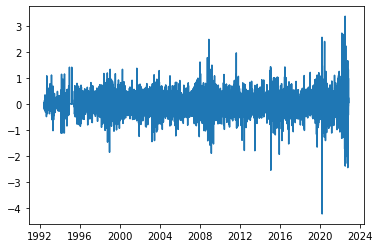

FV COMDTY


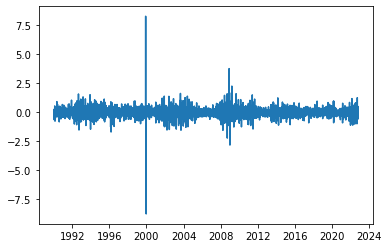

G  COMDTY


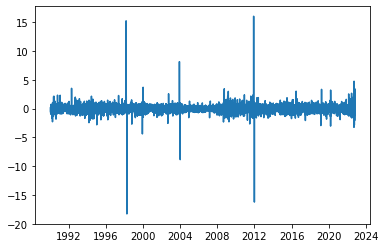

IK COMDTY


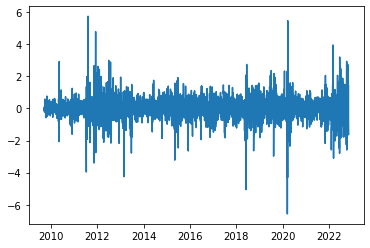

JB COMDTY


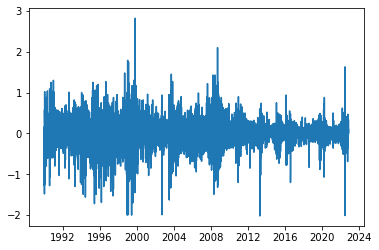

L  COMDTY


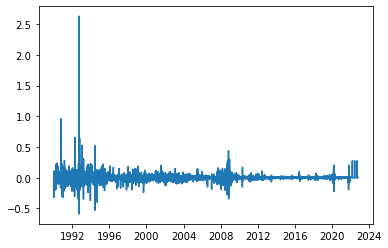

OAT COMDTY


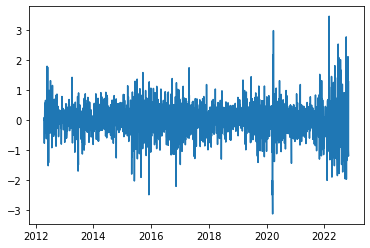

OE COMDTY


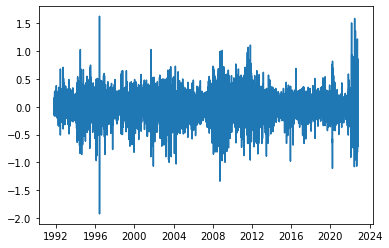

RX COMDTY


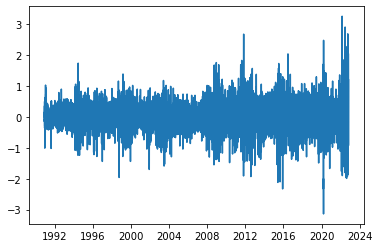

TU COMDTY


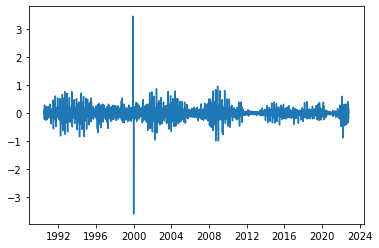

TY COMDTY


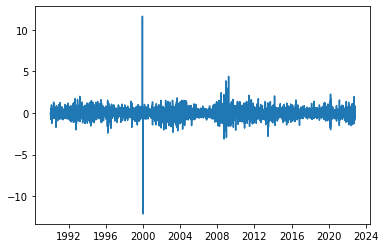

US COMDTY


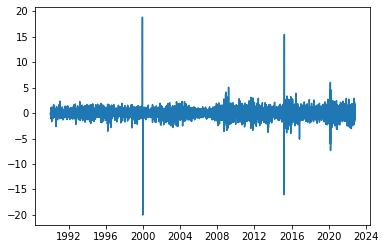

FF COMDTY


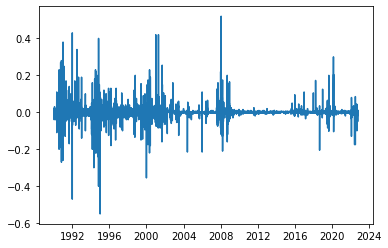

WN COMDTY


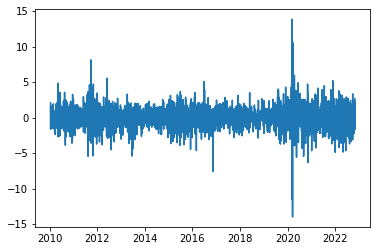

YE COMDTY


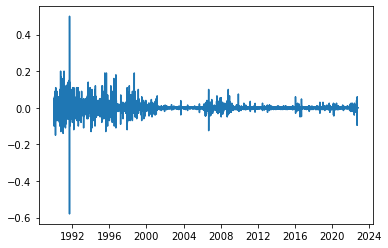

In [16]:
for i in range(0, 47):
    print(ret_adj_df.columns[i])
    plt.plot(ret_adj_df.iloc[:, i])
    plt.show()